In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import os, gc, random, cv2, sys, warnings
from tqdm import tqdm
from sklearn.cluster import KMeans
from string import ascii_lowercase
from skimage.io import imread,imshow
from skimage.morphology import closing, opening, disk, label
from skimage.transform import resize
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, UpSampling2D, Lambda
from keras.losses import binary_crossentropy

seed = 42
random.seed = seed
np.random.seed = seed

%matplotlib inline
warnings.filterwarnings('ignore')
dsb_data_dir = os.path.join('..', 'input','data-science-bowl-2018')
IMG_CHANNELS = 3

Using TensorFlow backend.


In [2]:
def load_img(choice=[1,1,1,1]):
    X_all = []
    Y_all = []
    if choice[0]:
        train_size = train_img_df.shape[0]
        X_train = np.zeros((train_size, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
        Y_train = np.zeros((train_size, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        print('Loading and resizing Stage1_train images and masks ... ')
        sys.stdout.flush()
        for n, row in tqdm(train_img_df.iterrows(), total=train_size):
            X_train[n] = resize(imread(row['images'][0])[:,:,:IMG_CHANNELS], (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
            masks = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
            for mask in row['masks']:
                mask_ = np.expand_dims(resize(imread(mask), (IMG_HEIGHT, IMG_WIDTH), mode='constant',preserve_range=True), axis=-1)
                masks = np.maximum(masks, mask_)
            Y_train[n] = masks
        X_all.append(X_train)
        Y_all.append(Y_train)
    if choice[1]:
        stage1_test_df = img_df.query('Stage=="stage1"')
        stage1_test_df = stage1_test_df.query('TrainingSplit=="test"')
        stage_1_test_img_df = load_path(stage1_test_df,train = False)
        stage1_solution = pd.read_csv(os.path.join('..', 'input','stage1-test-solution','stage1_solution.csv'))
        rows=[]
        for i,row in stage1_solution.iterrows():
            rows.append(rleToMask(row['EncodedPixels'],row['Height'],row['Width']))
        stage1_solution['masks']=pd.Series(rows)
        rows=[]
        for n_group, n_rows in stage1_solution.groupby(["ImageId"]):
            c_row = {"ImageId": n_group}
            c_row['masks'] = n_rows['masks'].values.tolist()
            rows += [c_row]
        merge = pd.merge(stage_1_test_img_df, pd.DataFrame(rows), on='ImageId')
        solution_size = merge.shape[0]
        X_train_solution = np.zeros((solution_size, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
        Y_train_solution = np.zeros((solution_size, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        print('Loading and resizing Stage1_test_solutions images and masks ... ')
        sys.stdout.flush()
        for n, row in tqdm(merge.iterrows(), total=solution_size):
            X_train_solution[n] = resize(imread(row['images'][0])[:,:,:IMG_CHANNELS], (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
            masks = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
            for mask in row['masks']:
                mask_ = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant',preserve_range=True), axis=-1)
                masks = np.maximum(masks, mask_)
            Y_train_solution[n] = masks
        X_all.append(X_train_solution)
        Y_all.append(Y_train_solution)
    if choice[2]: 
        TRAIN_PATH =  '../input/bowl2018-external/extra_data/extra_data/'
        all_images = glob(os.path.join(TRAIN_PATH, '*', '*','*'))
        extra_img_df = pd.DataFrame({'path': all_images})
        extra_img_df['ImageType'] = extra_img_df['path'].map(lambda in_path: in_path.split('/')[-2])
        extra_img_df['ImageId'] = extra_img_df['path'].map(lambda in_path: in_path.split('/')[-3])
        extra_img_df['Stage'] = "stage1"
        extra_train_img_df = load_path(extra_img_df,train = True)
        extra_train_size = extra_train_img_df.shape[0]
        X_extra_train = np.zeros((extra_train_size, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
        Y_extra_train = np.zeros((extra_train_size, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        print('Loading and resizing Extra_train images and masks ... ')
        sys.stdout.flush()
        for n, row in tqdm(extra_train_img_df.iterrows(), total=extra_train_size):
            X_extra_train[n] = resize(cv2.cvtColor(cv2.imread(row['images'][0]), cv2.COLOR_BGR2RGB)[:,:,:IMG_CHANNELS],
                                      (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
            masks = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float64)
            for mask in row['masks']:       
                mask_ = np.expand_dims(resize(cv2.cvtColor(cv2.imread(mask), cv2.COLOR_BGR2GRAY), (IMG_HEIGHT, IMG_WIDTH), mode='constant',preserve_range=True),axis=-1)
                masks = masks + mask_
                masks[masks>255.0]=0# clean overlap  
            Y_extra_train[n] = np.array(masks,dtype=np.bool)
        X_all.append(X_extra_train)
        Y_all.append(Y_extra_train)
    if choice[3]: 
        all_extra = glob(os.path.join("../input/tnbc-nucleisegmentation-clean/tnbc_nucleisegmentation_clean/TNBC_NucleiSegmentation", '*', '*', '*'))
        extra_df = pd.DataFrame({'path': all_extra})
        extra_df['ImageId'] = extra_df['path'].map(lambda in_path: in_path.split('/')[-3])
        extra_df['ImageType'] = extra_df['path'].map(lambda in_path: in_path.split('/')[-2])
        extra_df['TrainingSplit'] = "train"
        extra_df['Stage'] = "stage1"
        extra__df = extra_df.query('TrainingSplit=="train"')
        extra_img_df = load_path(extra__df,train = True)
        etrain_size = extra_img_df.shape[0]
        X_t_extra = np.zeros((etrain_size, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
        Y_t_extra = np.zeros((etrain_size, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        print('Loading and resizing Extra_train_2 images and masks ... ')
        sys.stdout.flush()
        for n, row in tqdm(extra_img_df.iterrows(), total=etrain_size):
            X_t_extra[n] = resize(imread(row['images'][0])[:,:,:IMG_CHANNELS], (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
            masks = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
            for mask in row['masks']:
                mask_ = np.expand_dims(resize(imread(mask), (IMG_HEIGHT, IMG_WIDTH), mode='constant',preserve_range=True), axis=-1)
                masks = np.maximum(masks, mask_)
            Y_t_extra[n] = masks
        X_all.append(X_t_extra)
        Y_all.append(Y_t_extra)
    X_train = np.concatenate([i for i in X_all],axis=0)
    Y_train = np.concatenate([i for i in Y_all],axis=0)
    return X_train,Y_train

def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2,y_true)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def clean_img(x):
    return opening(closing(np.squeeze(x), disk(1)), disk(3))

def create_color_cluster(df, cluster_maker = None, cluster_count = 3):
    if cluster_maker is None:
        cluster_maker = KMeans(cluster_count)
        cluster_maker.fit(df[['Green', 'Red-Green', 'Red-Green-Sd']])
    df['cluster-id'] = np.argmin(cluster_maker.transform(df[['Green', 'Red-Green', 'Red-Green-Sd']]),-1)
    df['cluster-id'] = df['cluster-id'].map(lambda x: ascii_lowercase[x])
    return df, cluster_maker

def show_imgs_KM(X_train,img_df):
    nb_img = 5
    imgs = []
    cat =  img_df['cluster-id'].unique().tolist()
    for i in cat:
        l = img_df.index[img_df['cluster-id']==i].tolist()
        for j in np.random.randint(0,len(l),nb_img):
            imgs.append(X_train[l[j]])
    row = len(cat)
    fig, ax = plt.subplots(row, nb_img, sharex='col', sharey='row',figsize=(35,20))
    fig.suptitle("Train Batch",fontsize=20)
    for i in range(row):
        for j in range(nb_img):
            ax[i, 0].text(-600,250, str('Group: {}'.format(cat[i])),fontsize=18)
            ax[i, j].imshow(imgs[i*nb_img+j])
        
def load_path(df,train):
    '''
    return df : Change ['images'] and ['masks'] to include every path to load data
    Train = False to ignore ['masks'] column
    '''
    rows = []
    group_cols = ['Stage', 'ImageId']
    if train :
        for n_group, n_rows in df.groupby(group_cols):
            c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
            c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
            c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
            rows += [c_row]
    else :
        for n_group, n_rows in df.groupby(group_cols):
            c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
            c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
            rows += [c_row]
    return pd.DataFrame(rows)  
        
def read_and_stack(in_img_list):
    return np.array((np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)),dtype=np.uint8)

def rleToMask(rleString,height,width):
    rows,cols = height,width
    rleNumbers = [int(numstring) for numstring in rleString.split(' ')]
    rlePairs = np.array(rleNumbers).reshape(-1,2)
    img = np.zeros(rows*cols,dtype=np.uint8)
    for index,length in rlePairs:
        index -= 1
        img[index:index+length] = 255
    img = img.reshape(cols,rows)
    img = img.T
    return img

def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cut_off = 0.5):
    lab_img = label(x>cut_off)
    if lab_img.max()<1:
        lab_img[0,0] = 1 # ensure at least one prediction per image
    for i in range(1, lab_img.max()+1):
        yield rle_encoding(lab_img==i)

def load_path(df,train):
    '''
    return df : Change ['images'] and ['masks'] to include every path to load data
    Train = False to ignore ['masks'] column
    '''
    rows = []
    group_cols = ['Stage', 'ImageId']
    if train :
        for n_group, n_rows in df.groupby(group_cols):
            c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
            c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
            c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
            rows += [c_row]
    else :
        for n_group, n_rows in df.groupby(group_cols):
            c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
            c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
            rows += [c_row]
    return pd.DataFrame(rows)    
        

def process(img_rgb):
    img_gray=img_rgb[:,:,1]
    circle7=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
    img_open=cv2.morphologyEx(img_gray, cv2.MORPH_OPEN, circle7)
    img_th=cv2.threshold(img_open,0,255,cv2.THRESH_OTSU)[1]
    if(np.sum(img_th==255)>np.sum(img_th==0)):
        img_th=cv2.bitwise_not(img_th)
    bin_open=cv2.morphologyEx(img_th, cv2.MORPH_OPEN, circle7) 
    cc=cv2.connectedComponents(bin_open)[1]
    return cc


def out_pred_df(test_df):
    test_img_df = load_path(test_df,train=False)
    test_img_df['images'] = test_img_df['images'].map(read_and_stack)
    for _,i in test_img_df.iterrows():
        if len(i['images'].shape)==2:
            img_correct = np.expand_dims(i['images'], axis=2)
            img_RG = np.append(img_correct,img_correct,2)
            img_RGB = np.append(img_RG,img_correct,2)
            i['images'] = img_RGB
    test_img_df['images'] = test_img_df['images'].map(lambda x: x[:,:,:IMG_CHANNELS])
    print(test_img_df.shape[0], 'images to process')
    test_img_df['masks'] = test_img_df['images'].map(lambda x: process(x))
    test_img_df['rles'] = test_img_df['masks'].map(lambda x: list(prob_to_rles(x)))
    out_pred_list = []
    for _, c_row in test_img_df.iterrows():
        for c_rle in c_row['rles']:
            out_pred_list+=[dict(EncodedPixels = ' '.join(np.array(c_rle).astype(str)),ImageId=c_row['ImageId'])]
    out_pred_df = pd.DataFrame(out_pred_list)
    print(out_pred_df.shape[0], 'regions found for', test_img_df.shape[0], 'images')
    gc.collect()
    return out_pred_df[['ImageId', 'EncodedPixels']]

## Référencement données totales (Stage1[train/test] | Stage2[test])

In [3]:
all_images = glob(os.path.join(dsb_data_dir, 'stage*', '*', '*', '*'))
all_images.remove('../input/data-science-bowl-2018/stage2_test_final/170bc41b2095177cccd3d4c8977c619147580f1d93b4fe9701eddd77736d4ece/images/170bc41b2095177cccd3d4c8977c619147580f1d93b4fe9701eddd77736d4ece.png')
img_df = pd.DataFrame({'path': all_images})
img_df['ImageId'] = img_df['path'].map(lambda in_path: in_path.split('/')[-3])
img_df['ImageType'] = img_df['path'].map(lambda in_path: in_path.split('/')[-2])
img_df['TrainingSplit'] = img_df['path'].map(lambda in_path: in_path.split('/')[-4].split('_')[1])
img_df['Stage'] = img_df['path'].map(lambda in_path: in_path.split('/')[-4].split('_')[0])
img_df.describe()

path   ...     Stage
count                                               33214   ...     33214
unique                                              33214   ...         2
top     ../input/data-science-bowl-2018/stage1_train/1...   ...    stage1
freq                                                    1   ...     30196

[4 rows x 5 columns]

In [4]:
test_df_tot = img_df.query('TrainingSplit=="test"')
test_df_stage_2 = test_df_tot.query('Stage=="stage2"')

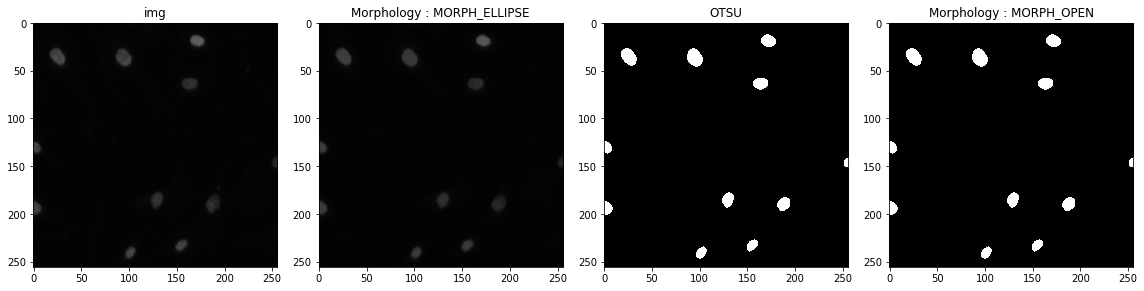

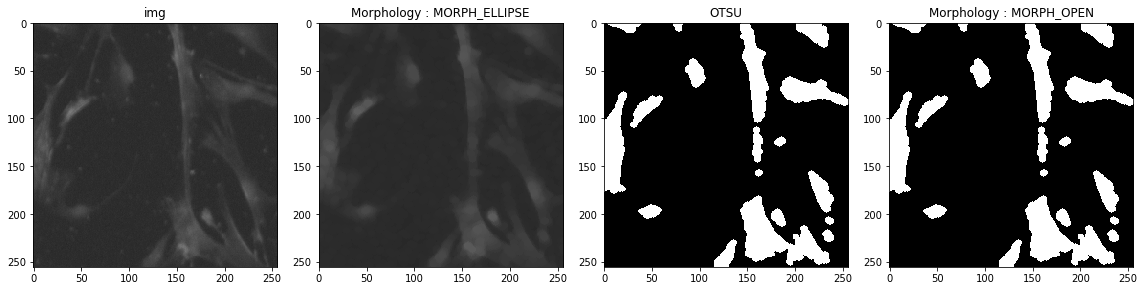

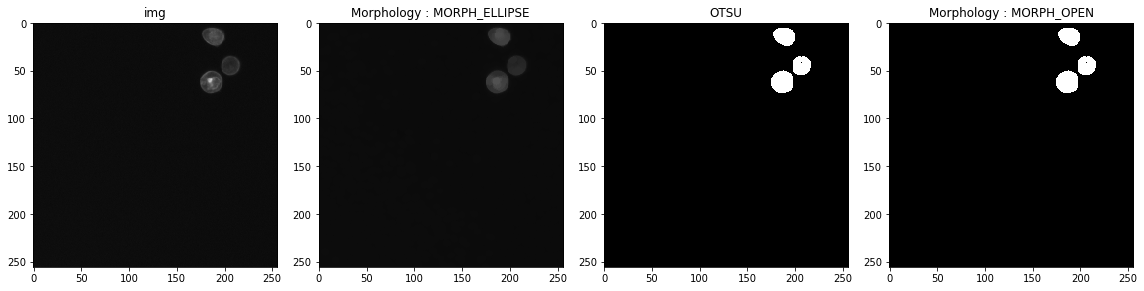

In [5]:
test_img_df = load_path(test_df_stage_2.sample(3),train=False)
test_img_df['images'] = test_img_df['images'].map(read_and_stack)
test_img_df['images'] = test_img_df['images'].map(lambda x: x[:,:,:IMG_CHANNELS])
imgs = [test_img_df['images'][i] for i in range(test_img_df.shape[0])]

for i in imgs:
    fig = plt.figure(figsize=(16,5))
    img_gray=i[:,:,1]
    fig.add_subplot(1,4,1).set_title("img", fontsize='large')
    imshow(img_gray)
    circle7=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
    img_open=cv2.morphologyEx(img_gray, cv2.MORPH_OPEN, circle7)
    fig.add_subplot(1,4,2).set_title("Morphology : MORPH_ELLIPSE", fontsize='large')
    imshow(img_open)
    img_th=cv2.threshold(img_open,0,255,cv2.THRESH_OTSU)[1]
    if(np.sum(img_th==255)>np.sum(img_th==0)):
        img_th=cv2.bitwise_not(img_th)
    fig.add_subplot(1,4,3).set_title("OTSU", fontsize='large')
    imshow(img_th)
    bin_open=cv2.morphologyEx(img_th, cv2.MORPH_OPEN, circle7) 
    fig.add_subplot(1,4,4).set_title("Morphology : MORPH_OPEN", fontsize='large')
    imshow(bin_open)
    cc=cv2.connectedComponents(bin_open)[1]

In [6]:
l = int(np.floor(test_df_stage_2.shape[0]/4))
test_one_df = test_df_stage_2[:l]
test_two_df = test_df_stage_2[l:l*2]
test_three_df = test_df_stage_2[l*2:l*3]
test_four_df = test_df_stage_2[l*3:]

In [7]:
default = pd.DataFrame([dict(ImageId='170bc41b2095177cccd3d4c8977c619147580f1d93b4fe9701eddd77736d4ece',
                   EncodedPixels = '1 1')])

pd.concat([out_pred_df(test_one_df),
           out_pred_df(test_two_df),
           out_pred_df(test_three_df),
           out_pred_df(test_four_df),
           default]).reindex(columns = ['ImageId', 'EncodedPixels']).to_csv('predictions.csv', index = False)

754 images to process
20069 regions found for 754 images
754 images to process
23212 regions found for 754 images
754 images to process
20410 regions found for 754 images
756 images to process
22617 regions found for 756 images


## Kmeans IoU

In [8]:
IMG_HEIGHT = 512
IMG_WIDTH = 512
IMG_CHANNELS = 3
train_df = img_df.query('TrainingSplit=="train"')
train_img_df = load_path(train_df,train = True)
train_size = train_img_df.shape[0]
X_train,Y_train = load_img([1,1,0,0])
train_size = X_train.shape[0]

Loading and resizing Stage1_train images and masks ... 


100%|██████████| 670/670 [07:28<00:00,  3.35it/s]


Loading and resizing Stage1_test_solutions images and masks ... 


100%|██████████| 65/65 [00:39<00:00,  1.88it/s]


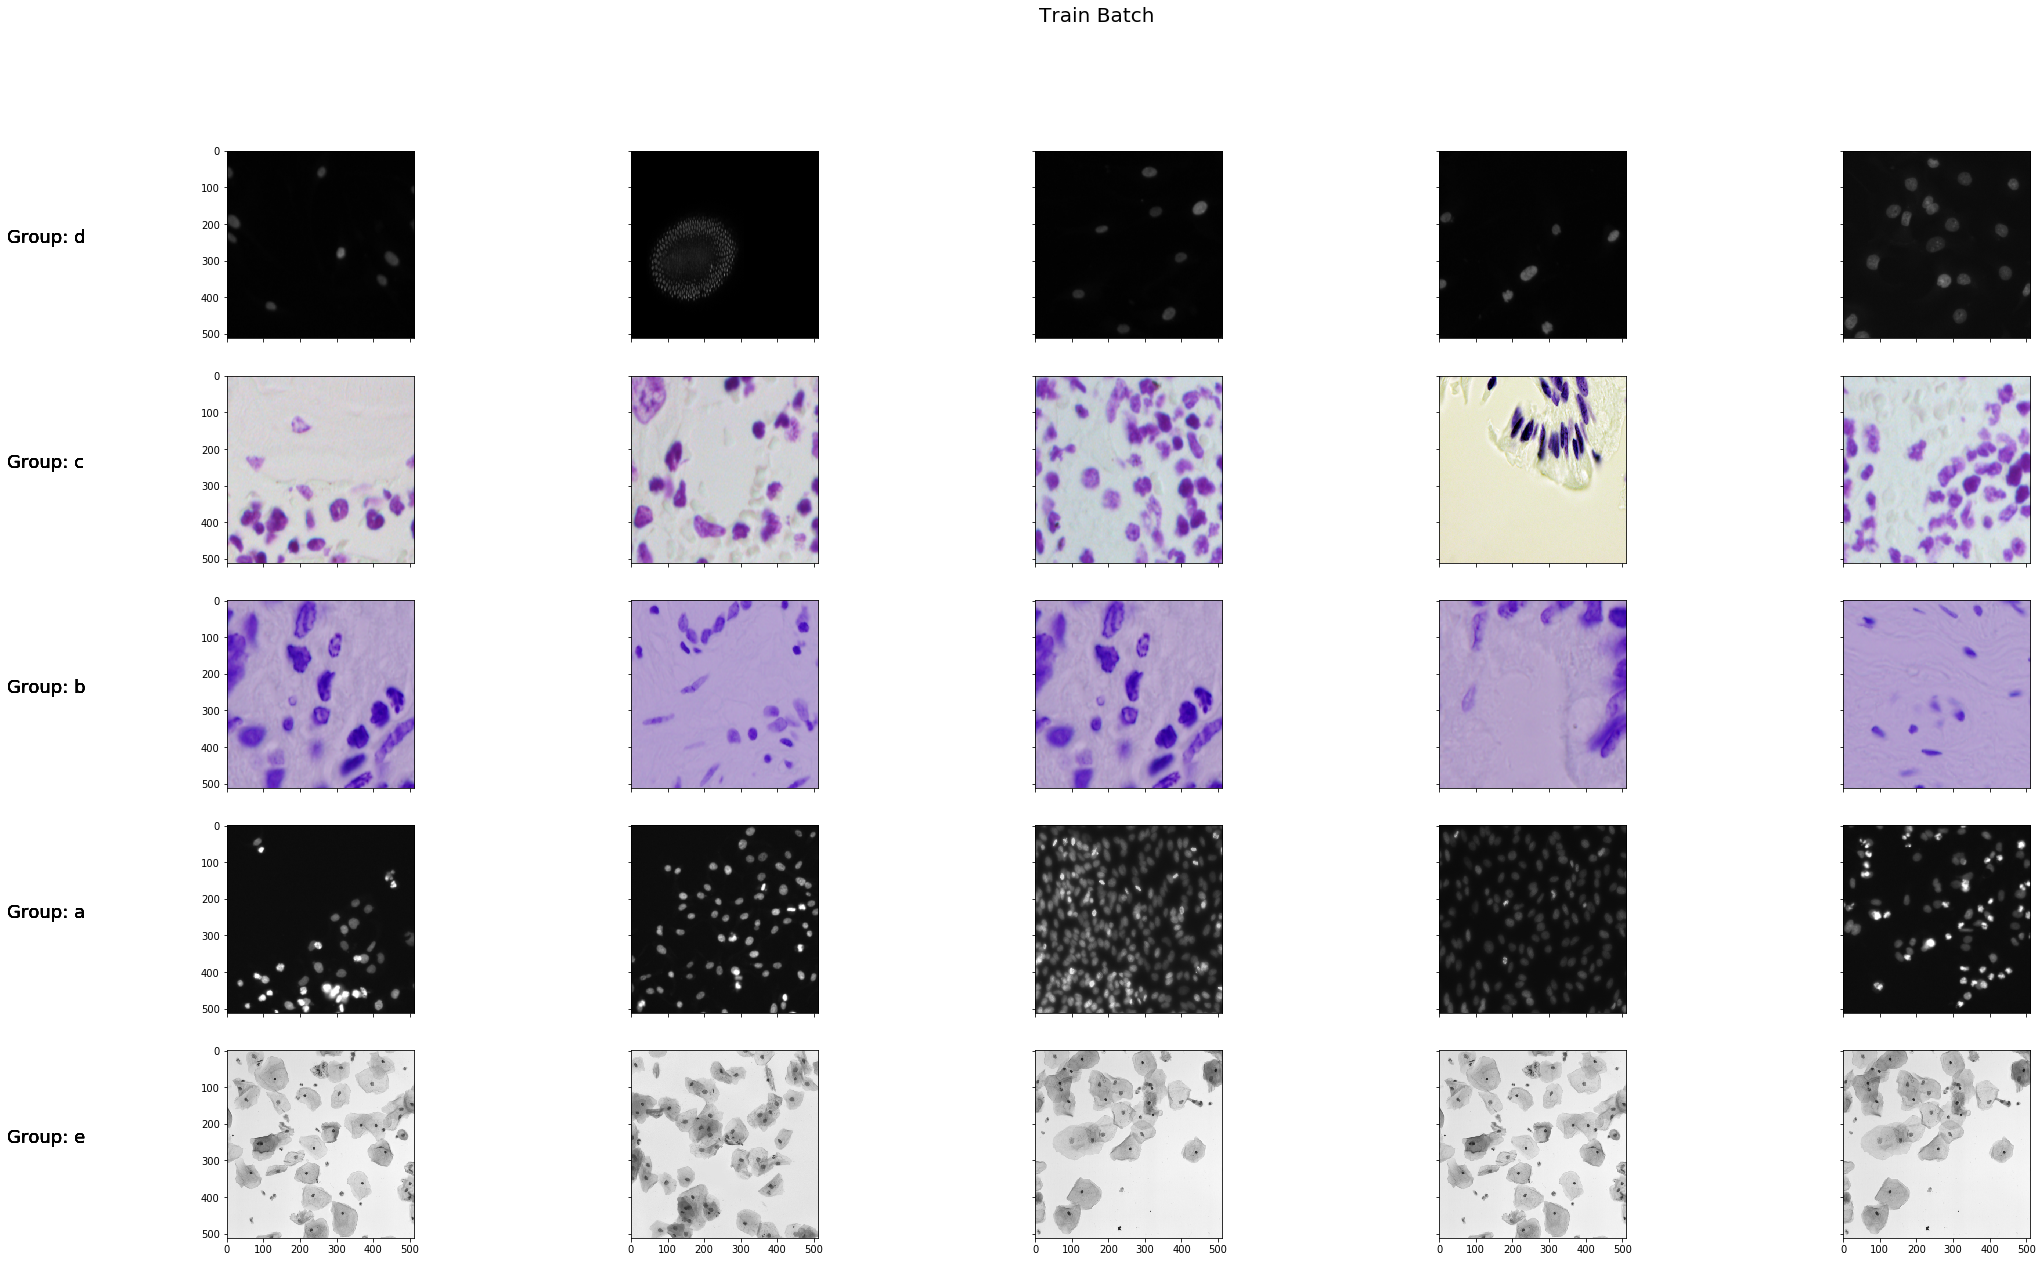

In [9]:
rows = []
for i in range(train_size):
    row = {'Red' : np.mean(X_train[i,:,:,0])}
    row['Green'] = np.mean(X_train[i,:,:,1])
    row['Blue'] = np.mean(X_train[i,:,:,2])
    row['Grey'] = np.mean(X_train[i,:,:,2])
    row['Red-Green'] = np.mean(X_train[i,:,:,0]-X_train[i,:,:,1])
    row['Red-Green-Sd'] = np.std(X_train[i,:,:,0]-X_train[i,:,:,1])
    rows += [row]
colors = pd.DataFrame(rows)

from joblib import dump, load
cluster_maker = load('../input/kmean-sb2018/Kmean.joblib') 
colors['cluster-id'] = np.argmin(cluster_maker.transform(colors),-1)
colors['cluster-id'] = colors['cluster-id'].map(lambda x: ascii_lowercase[x])
show_imgs_KM(X_train,colors)

In [10]:
#clust_n = [1,0,0,1]
#fig = plt.figure(figsize=(18,7))
#fig.suptitle("Img : "+str(clust_a[clust_n[3]]),fontsize=20)
#fig.add_subplot(1,3,1).set_title("img", fontsize='large')
#imshow(X_train[clust_a[clust_n[3]]])
#fig.add_subplot(1,3,2).set_title("Ground truth", fontsize='large')
#imshow(np.squeeze(Y_train[clust_a[clust_n[3]]]))
#fig.add_subplot(1,3,3).set_title("Pred", fontsize='large')
#imshow(process(X_train[clust_a[clust_n[3]]]))

#fig = plt.figure(figsize=(18,7))
#fig.suptitle("Img : "+str(clust_b[clust_n[3]]),fontsize=20)
#fig.add_subplot(1,3,1).set_title("img", fontsize='large')
#imshow(X_train[clust_b[clust_n[3]]])
#fig.add_subplot(1,3,2).set_title("Ground truth", fontsize='large')
#imshow(np.squeeze(Y_train[clust_b[clust_n[3]]]))
#fig.add_subplot(1,3,3).set_title("Pred", fontsize='large')
#imshow(process(X_train[clust_b[clust_n[3]]]))

#fig = plt.figure(figsize=(18,7))
#fig.suptitle("Img : "+str(clust_c[clust_n[3]]),fontsize=20)
#fig.add_subplot(1,3,1).set_title("img", fontsize='large')
#imshow(X_train[clust_c[clust_n[3]]])
#fig.add_subplot(1,3,2).set_title("Ground truth", fontsize='large')
#imshow(np.squeeze(Y_train[clust_d[clust_n[3]]]))
#fig.add_subplot(1,3,3).set_title("Pred", fontsize='large')
#imshow(process(X_train[clust_c[clust_n[3]]]))

#fig = plt.figure(figsize=(18,7))
#fig.suptitle("Img : "+str(clust_d[clust_n[3]]),fontsize=20)
#fig.add_subplot(1,3,1).set_title("img", fontsize='large')
#imshow(X_train[clust_d[clust_n[3]]])
#fig.add_subplot(1,3,2).set_title("Ground truth", fontsize='large')
#imshow(np.squeeze(Y_train[clust_d[clust_n[3]]]))
#fig.add_subplot(1,3,3).set_title("Pred", fontsize='large')
#imshow(process(X_train[clust_d[clust_n[3]]]))

## IOU per cluster

In [11]:
TRAIN_PATH =  '../input/bowl2018-external/extra_data/extra_data/'
all_images = glob(os.path.join(TRAIN_PATH, '*', '*','*'))
extra_img_df = pd.DataFrame({'path': all_images})
extra_img_df['ImageType'] = extra_img_df['path'].map(lambda in_path: in_path.split('/')[-2])
extra_img_df['ImageId'] = extra_img_df['path'].map(lambda in_path: in_path.split('/')[-3])
extra_img_df['Stage'] = "stage1"
extra_train_img_df = load_path(extra_img_df,train = True)
extra_train_size = extra_train_img_df.shape[0]
X_extra_train = np.zeros((extra_train_size, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_extra_train = np.zeros((extra_train_size, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Loading and resizing Extra_train images and masks ... ')
sys.stdout.flush()
for n, row in tqdm(extra_train_img_df.iterrows(), total=extra_train_size):
    X_extra_train[n] = resize(cv2.cvtColor(cv2.imread(row['images'][0]), cv2.COLOR_BGR2RGB)[:,:,:IMG_CHANNELS],
                              (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    masks = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float64)
    for mask in row['masks']:       
        mask_ = np.expand_dims(resize(cv2.cvtColor(cv2.imread(mask), cv2.COLOR_BGR2GRAY), (IMG_HEIGHT, IMG_WIDTH), mode='constant',preserve_range=True),axis=-1)
        masks = masks + mask_
        masks[masks>255.0]=0# clean overlap  
    Y_extra_train[n] = np.array(masks,dtype=np.bool)
    
all_extra = glob(os.path.join("../input/tnbc-nucleisegmentation-clean/tnbc_nucleisegmentation_clean/TNBC_NucleiSegmentation", '*', '*', '*'))
extra_df = pd.DataFrame({'path': all_extra})
extra_df['ImageId'] = extra_df['path'].map(lambda in_path: in_path.split('/')[-3])
extra_df['ImageType'] = extra_df['path'].map(lambda in_path: in_path.split('/')[-2])
extra_df['TrainingSplit'] = "train"
extra_df['Stage'] = "stage1"
extra__df = extra_df.query('TrainingSplit=="train"')
extra_img_df = load_path(extra__df,train = True)
etrain_size = extra_img_df.shape[0]
X_t_extra = np.zeros((etrain_size, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_t_extra = np.zeros((etrain_size, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Loading and resizing Extra_train_2 images and masks ... ')
sys.stdout.flush()
for n, row in tqdm(extra_img_df.iterrows(), total=etrain_size):
    X_t_extra[n] = resize(imread(row['images'][0])[:,:,:IMG_CHANNELS], (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    masks = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask in row['masks']:
        mask_ = np.expand_dims(resize(imread(mask), (IMG_HEIGHT, IMG_WIDTH), mode='constant',preserve_range=True), axis=-1)
        masks = np.maximum(masks, mask_)
    Y_t_extra[n] = masks

Loading and resizing Extra_train images and masks ... 


100%|██████████| 30/30 [10:24<00:00, 38.12s/it]


Loading and resizing Extra_train_2 images and masks ... 


100%|██████████| 50/50 [00:47<00:00,  1.22it/s]


In [12]:
clust_a = np.array(colors[colors['cluster-id'] == 'a'].index)
clust_b = np.array(colors[colors['cluster-id'] == 'b'].index)
clust_c = np.array(colors[colors['cluster-id'] == 'c'].index)
clust_d = np.array(colors[colors['cluster-id'] == 'd'].index)
clust_e = np.array(colors[colors['cluster-id'] == 'e'].index)
train_size_tot=train_size+Y_t_extra.shape[0]+Y_extra_train.shape[0]
print("Clust a :",len(clust_a)/train_size_tot,"%")
print("Clust b :",len(clust_b)/train_size_tot,"%")
print("Clust c :",len(clust_c)/train_size_tot,"%")
print("Clust d :",len(clust_d)/train_size_tot,"%")
print("Clust e :",len(clust_e)/train_size_tot,"%")
print("Classic_H&E :",len(Y_extra_train)/train_size_tot,"%")
print("tnbc :",len(Y_t_extra)/train_size_tot,"%")

Clust a : 0.10797546012269939 %
Clust b : 0.08957055214723926 %
Clust c : 0.05766871165644172 %
Clust d : 0.6269938650306749 %
Clust e : 0.0196319018404908 %
Classic_H&E : 0.03680981595092025 %
tnbc : 0.06134969325153374 %


In [13]:
mua = []
mub = []
muc = []
mud = []
mue = []
he = []
tnbc = []
for i in clust_a:
    pred = clean_img(np.squeeze(process(X_train[i])))
    mua.append(iou_metric(np.squeeze(np.array(Y_train[i])),pred))
print("Clust a :",(sum(mua) / len(mua)))
for i in clust_b:
    pred = clean_img(np.squeeze(process(X_train[i])))
    mub.append(iou_metric(np.squeeze(np.array(Y_train[i])),pred))
print("Clust b :",(sum(mub) / len(mub)))
for i in clust_c:
    pred = clean_img(np.squeeze(process(X_train[i])))
    muc.append(iou_metric(np.squeeze(np.array(Y_train[i])),pred))
print("Clust c :",(sum(muc) / len(muc)))
for i in clust_d:
    pred = clean_img(np.squeeze(process(X_train[i])))
    mud.append(iou_metric(np.squeeze(np.array(Y_train[i])),pred))
print("Clust d :",(sum(mud) / len(mud)))
for i in clust_e:
    pred = clean_img(np.squeeze(process(X_train[i])))
    mue.append(iou_metric(np.squeeze(np.array(Y_train[i])),pred))
print("Clust e :",(sum(mue) / len(mue)))
for i in range(len(Y_extra_train)):
    pred = clean_img(np.squeeze(process(X_extra_train[i])))
    he.append(iou_metric(np.squeeze(np.array(Y_extra_train[i])),pred))
print("Classic_H&E :",(sum(he) / len(he)))
for i in range(len(Y_t_extra)):
    pred = clean_img(np.squeeze(process(X_t_extra[i])))
    tnbc.append(iou_metric(np.squeeze(np.array(Y_t_extra[i])),pred))
print("tnbc :",(sum(tnbc) / len(tnbc)))

pd.DataFrame({'Clust_a': pd.Series(mua), 'Clust_b': pd.Series(mub), 'Clust_c': pd.Series(muc),
 'Clust_d': pd.Series(mud), 'Clust_e': pd.Series(mue), 'Classic_H&E': pd.Series(he), 'tnbc': pd.Series(tnbc)}).to_csv('accuracy.csv', index = False)

Clust a : 0.31896028579935637
Clust b : 0.24571961374173446
Clust c : 0.2813168071982586
Clust d : 0.4792335930967885
Clust e : 0.018828236776022744
Classic_H&E : 0.02022464528696919
tnbc : 0.052885944097999495


211 4e07a653352b30bb95b60ebc6c57afbc7215716224af731c51ff8d430788cd40
191 45f059cf21d85ecfce0eb93260516f1e2443d210e9a52f9ae2271d604aa3fcc5
141 33d0a9b24c25852ce35274b4b1777484ccd21f44dbe35491cc926e5948c1ce3e
369 8d29c5a03e0560c8f9338e8eb7bccf47930149c8173f9ba4b9279fb87d86cf6d
473 b214800de5ed4cc558f44d569495970f93c8c047f8e464c51d4bd5c276118423
10 TCGA-AY-A8YK-01A-01-TS1
41 09_5


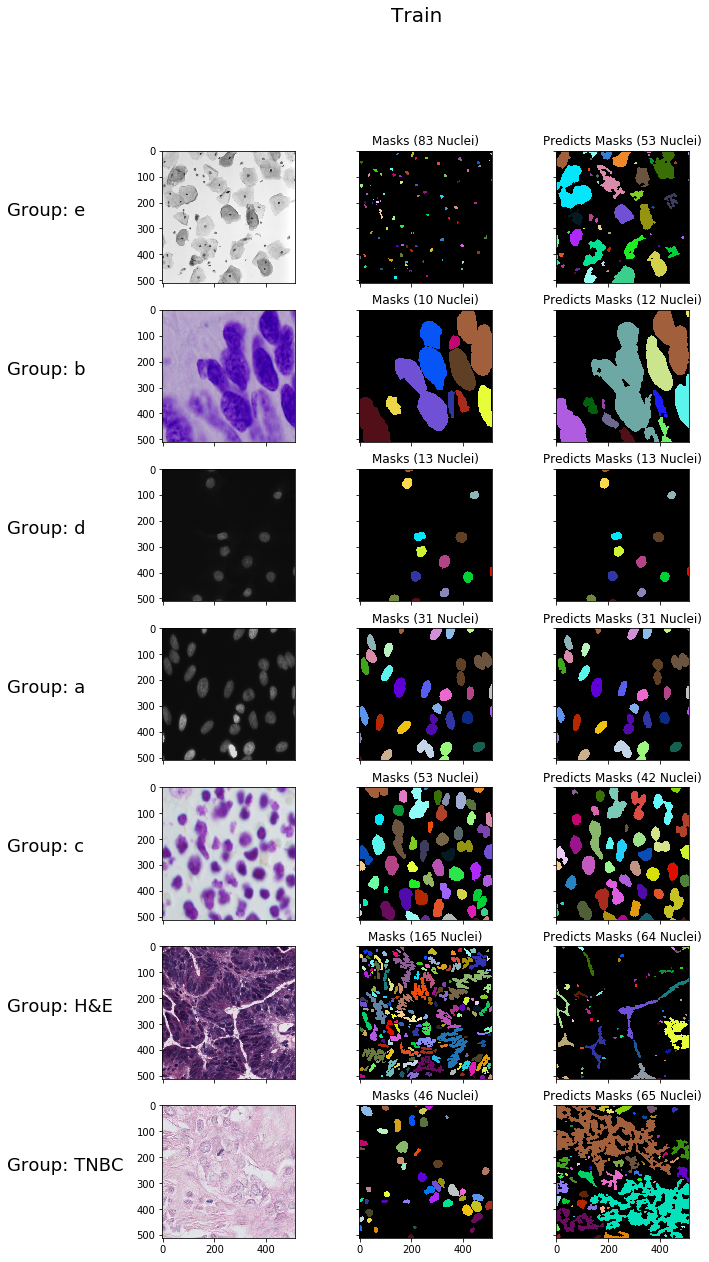

In [14]:
train_df = img_df.query('TrainingSplit=="train"')
train_img_df = load_path(train_df,train = True)
X_all = []
Y_all = []
train_img_df= train_img_df.iloc[[211,191,141,369,473]].reset_index()#######
train_size = train_img_df.shape[0]
X_train = np.zeros((train_size, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((train_size, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
for n, row in train_img_df.iterrows():
    print(row['index'], row['ImageId'])
    X_train[n] = resize(imread(row['images'][0])[:,:,:IMG_CHANNELS], (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    masks = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask in row['masks']:
        mask_ = np.expand_dims(resize(imread(mask), (IMG_HEIGHT, IMG_WIDTH), mode='constant',preserve_range=True), axis=-1)
        masks = np.maximum(masks, mask_)
    Y_train[n] = masks
X_all.append(X_train)
Y_all.append(Y_train)

TRAIN_PATH =  '../input/bowl2018-external/extra_data/extra_data/'
all_images = glob(os.path.join(TRAIN_PATH, '*', '*','*'))
extra_img_df = pd.DataFrame({'path': all_images})
extra_img_df['ImageType'] = extra_img_df['path'].map(lambda in_path: in_path.split('/')[-2])
extra_img_df['ImageId'] = extra_img_df['path'].map(lambda in_path: in_path.split('/')[-3])
extra_img_df['Stage'] = "stage1"
extra_train_img_df = load_path(extra_img_df,train = True)
extra_train_img_df = extra_train_img_df[extra_train_img_df.index ==10].reset_index()######
extra_train_size = extra_train_img_df.shape[0]
X_extra_train = np.zeros((extra_train_size, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_extra_train = np.zeros((extra_train_size, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

for n, row in extra_train_img_df.iterrows():
    print(str(row['index']), str(row['ImageId']))
    X_extra_train[n] = resize(cv2.cvtColor(cv2.imread(row['images'][0]), cv2.COLOR_BGR2RGB)[:,:,:IMG_CHANNELS],
                                (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    masks = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float64)
    for mask in row['masks']:       
        mask_ = np.expand_dims(resize(cv2.cvtColor(cv2.imread(mask), cv2.COLOR_BGR2GRAY), (IMG_HEIGHT, IMG_WIDTH), mode='constant',preserve_range=True),axis=-1)
        masks = masks + mask_
        masks[masks>255.0]=0# clean overlap  
    Y_extra_train[n] = np.array(masks,dtype=np.bool)
X_all.append(X_extra_train)
Y_all.append(Y_extra_train)

all_extra = glob(os.path.join("../input/tnbc-nucleisegmentation-clean/tnbc_nucleisegmentation_clean/TNBC_NucleiSegmentation", '*', '*', '*'))
extra_df = pd.DataFrame({'path': all_extra})
extra_df['ImageId'] = extra_df['path'].map(lambda in_path: in_path.split('/')[-3])
extra_df['ImageType'] = extra_df['path'].map(lambda in_path: in_path.split('/')[-2])
extra_df['TrainingSplit'] = "train"
extra_df['Stage'] = "stage1"
extra__df = extra_df.query('TrainingSplit=="train"')
extra_img_df = load_path(extra__df,train = True)
extra_img_df = extra_img_df[extra_img_df.index ==41].reset_index()######
etrain_size = extra_img_df.shape[0]
X_t_extra = np.zeros((etrain_size, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_t_extra = np.zeros((etrain_size, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
for n, row in extra_img_df.iterrows():
    print(str(row['index']), str(row['ImageId']))
    X_t_extra[n] = resize(imread(row['images'][0])[:,:,:IMG_CHANNELS], (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    masks = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask in row['masks']:
        mask_ = np.expand_dims(resize(imread(mask), (IMG_HEIGHT, IMG_WIDTH), mode='constant',preserve_range=True), axis=-1)
        masks = np.maximum(masks, mask_)
    Y_t_extra[n] = masks
X_all.append(X_t_extra)
Y_all.append(Y_t_extra)


X_train = np.concatenate([i for i in X_all],axis=0)
Y_train = np.concatenate([i for i in Y_all],axis=0)


from scipy import ndimage
from matplotlib.colors import ListedColormap
rand_cmap = ListedColormap(np.random.rand(256,3))
cat = ['e','b','d','a','c','H&E','TNBC']
row = 7
col = 3
fig, ax = plt.subplots(row, col, sharex='col', sharey='row',figsize=(10,20))
fig.suptitle("Train",fontsize=20)
for i in range(row):
        ax[i, 0].text(-600,250, str('Group: {}'.format(cat[i])),fontsize=18)
        ax[i, 0].imshow(X_train[i])
        labels, nlabels = ndimage.label(np.squeeze(label(Y_train[i])))
        label_arrays = []
        for label_num in range(1,nlabels+1):
            label_mask = np.where(labels == label_num, 1, 0)
            label_arrays.append(label_mask)
        labels_for_display = np.where(labels > 0, labels, np.nan)
        ax[i, 1].set_facecolor('black')
        ax[i, 1].imshow(labels_for_display, cmap=rand_cmap)
        ax[i, 1].set_title('Masks ({} Nuclei)'.format(nlabels))
        labels, nlabels = ndimage.label(np.squeeze(label(process(X_train[i]))))
        label_arrays = []
        for label_num in range(1,nlabels+1):
            label_mask = np.where(labels == label_num, 1, 0)
            label_arrays.append(label_mask)
        labels_for_display = np.where(labels > 0, labels, np.nan)
        ax[i, 2].set_facecolor('black')
        ax[i, 2].imshow(labels_for_display, cmap=rand_cmap)
        ax[i, 2].set_title('Predicts Masks ({} Nuclei)'.format(nlabels))

1027 5390acefd575cf9b33413ddf6cbb9ce137ae07dc04616ba24c7b5fe476c827d2
1750 914e7461bbac448390aa3ea923e00995816a4e68b792493cb73dfc6a0d43bd71
1984 a47ad05e76ed1bee4f1604c8cfea235b69ad5bb86a60970dfe1a2f37bf5de2e1
538 2ba8b85d599b9da90a0ef76dbe5372976770bfc827910c54d1492a34e4f531e5
411 219c6c29615c816476a71ed82c7e50fdcca4727020e0e52c019c6d252d6569d0


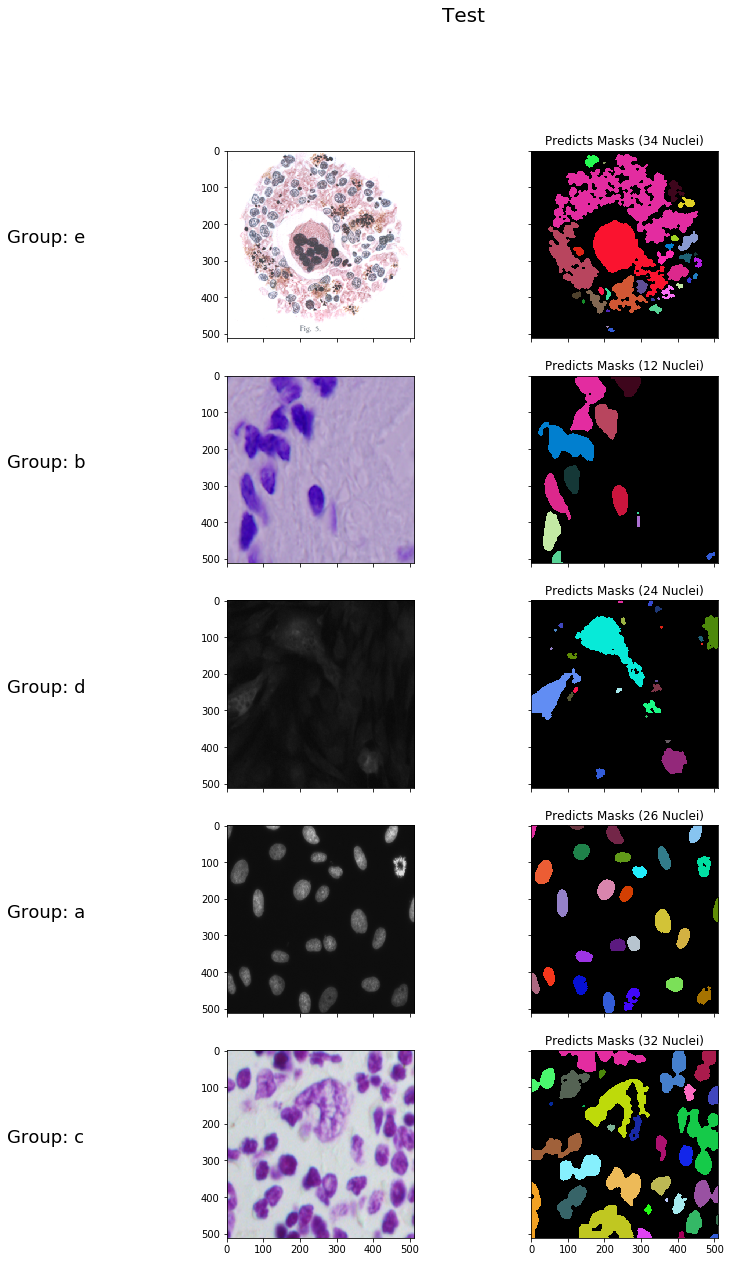

In [15]:
test_df_tot = img_df.query('TrainingSplit=="test"')
test_df = test_df_tot.query('Stage=="stage2"')
test_img_df = load_path(test_df,train=False)
test_img_df= test_img_df.iloc[[1027,1750,1984,538,411]].reset_index()
test_size = test_img_df.shape[0]
X_test = np.zeros((test_size, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sys.stdout.flush()
for n, row in test_img_df.iterrows():
    print(row['index'], row['ImageId'])
    img = imread(row['images'][0])
    if len(img.shape)==2:
        img_correct = np.expand_dims(img/255., axis=2)
        img_RG = np.append(img_correct,img_correct,2)
        img_RGB = np.append(img_RG,img_correct,2)
        img = img_RGB
    img = img[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

from scipy import ndimage
from matplotlib.colors import ListedColormap
rand_cmap = ListedColormap(np.random.rand(256,3))
cat = ['e','b','d','a','c']
row = 5
col = 2
fig, ax = plt.subplots(row, col, sharex='col', sharey='row',figsize=(10,20))
fig.suptitle("Test",fontsize=20)
for i in range(row):
        ax[i, 0].text(-600,250, str('Group: {}'.format(cat[i])),fontsize=18)
        ax[i, 0].imshow(X_test[i])
        labels, nlabels = ndimage.label(np.squeeze(label(process(X_test[i]))))
        label_arrays = []
        for label_num in range(1,nlabels+1):
            label_mask = np.where(labels == label_num, 1, 0)
            label_arrays.append(label_mask)
        labels_for_display = np.where(labels > 0, labels, np.nan)
        ax[i, 1].set_facecolor('black')
        ax[i, 1].imshow(labels_for_display, cmap=rand_cmap)
        ax[i, 1].set_title('Predicts Masks ({} Nuclei)'.format(nlabels))